In [0]:
!pip install -q pydrive

In [0]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set_style('whitegrid')

# Mount Google Drive

## Get Files

In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive/')

# authenticate and create the PyDrive clident
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# get reviews file
reviews = drive.CreateFile({'id':'1eLz9FkLyp_K50U_hC1Mh-cIaxoahEObT'})
reviews.GetContentFile('reviews.gz')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#Load Data

In [4]:
# load reviews
file_name = 'reviews.gz'
reviews_df = joblib.load(file_name)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15739967 entries, 0 to 99999
Data columns (total 6 columns):
user_id       int64
book_id       int64
rating        int64
read_at       object
started_at    object
Chunk         object
dtypes: int64(3), object(3)
memory usage: 840.6+ MB


## Books Distribution

There are 2.1M books

Books have 7.6 +/- 70 ratings on average

The minimum number of ratings is 1, and the maximum number of ratings is 20,756

75% of books only have 4 ratings

In [0]:
reviews_df['book_id'].value_counts().describe()

count    2.080190e+06
mean     7.566601e+00
std      6.996541e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      2.075600e+04
Name: book_id, dtype: float64

In [57]:
reviews_df['book_id'].value_counts().median()

1.0

## Users Distribution

There are 465k users

Users have 33.8 +/- 117 ratings on average

The minimum number of ratings is 1, and the maximum number of ratings is 21,811

75% of users only have 22 ratings

In [0]:
reviews_df['user_id'].value_counts().describe()

count    465323.000000
mean         33.825895
std         117.415545
min           1.000000
25%           2.000000
50%           6.000000
75%          22.000000
max       21811.000000
Name: user_id, dtype: float64

In [58]:
reviews_df['user_id'].value_counts().median()

6.0

# Trim Data

In [109]:
# Remove 0 star ratings
reviews_trimmed_df = reviews_df.copy()
reviews_trimmed_df = reviews_trimmed_df[reviews_trimmed_df['rating'] != 0]

# Remove books with less than 10 ratings
min_book_ratings = 10
keep_books = reviews_trimmed_df['book_id'].value_counts() >= min_book_ratings # keep books with at least n reviews
books_trimmed = keep_books.index[keep_books.values]
books_idx = reviews_trimmed_df['book_id'].isin(books_trimmed).to_numpy().nonzero()
reviews_trimmed_df = reviews_trimmed_df.iloc[books_idx]

# Remove users with less than 25 ratings
min_user_ratings = 25
keep_users = reviews_trimmed_df['user_id'].value_counts() >= min_user_ratings # keep users with at least m reviews
users_trimmed = keep_users.index[keep_users.values]
users_idx = reviews_trimmed_df['user_id'].isin(users_trimmed).to_numpy().nonzero()
reviews_trimmed_df = reviews_trimmed_df.iloc[users_idx]

print('The original number of reviews:', len(reviews_df))
print('The trimmed number of reviews:', len(reviews_trimmed_df))

The original number of reviews: 15739967
The trimmed number of reviews: 9321847


### Books Distribution

There are now 222k books

Books have 50.0 +/- 147 ratings on average

The minimum number of ratings is 1 (since we removed removed any users with less than *m* ratings, this removed some book ratings), and the maximum number of ratings is now 12,206

75% of books now have 32 ratings

In [110]:
reviews_trimmed_df['book_id'].value_counts().describe()

count    222047.000000
mean         41.981414
std         147.311227
min           1.000000
25%          11.000000
50%          17.000000
75%          32.000000
max       12206.000000
Name: book_id, dtype: float64

In [111]:
reviews_trimmed_df['book_id'].value_counts().median()

17.0

## Users Distribution

There are now 91k users

Users have 104.7 +/- 147 ratings on average

The minimum number of ratings is 25 (since we removed any users with less ratings), and the maximum number of ratings is now 5,765 (since books with only 1 rating with ratings of 0 stars were removed)

75% of users now have 112 ratings

In [112]:
reviews_trimmed_df['user_id'].value_counts().describe()

count    89058.000000
mean       104.671641
std        147.499551
min         25.000000
25%         35.000000
50%         57.000000
75%        112.000000
max       5765.000000
Name: user_id, dtype: float64

In [113]:
reviews_trimmed_df['user_id'].value_counts().median()

57.0

## Save Trimmed Data

In [114]:
file_name = 'reviews_trimmed.gz'
file_path = F'/content/drive/My Drive/Insight/Colab_Data/{file_name}'
joblib.dump(reviews_trimmed_df, file_path, compress=3)

['/content/drive/My Drive/Insight/Colab_Data/reviews_trimmed.gz']

# EDA

## Distribution of Book Ratings

<class 'matplotlib.axes._subplots.AxesSubplot'>


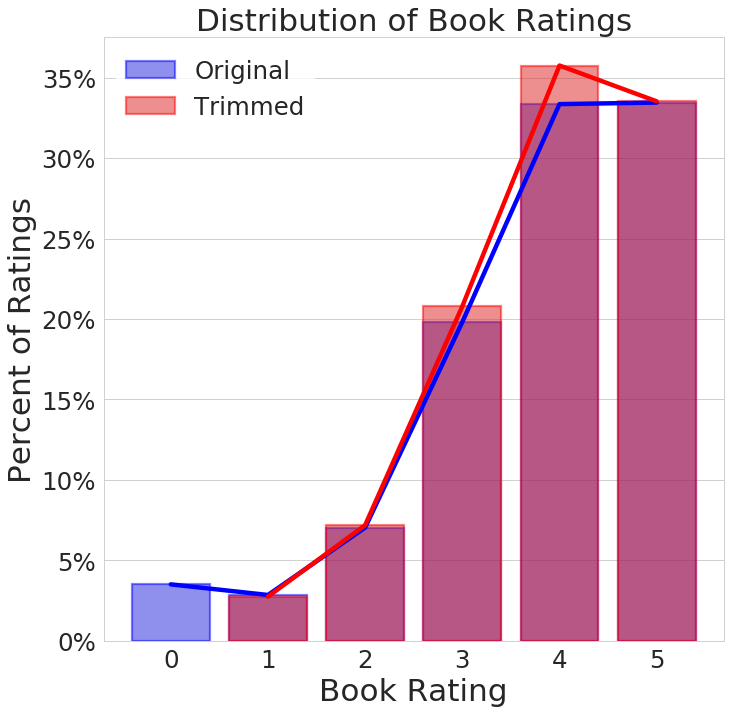

In [153]:
data1 = reviews_df['rating'].value_counts().sort_index(ascending=True)
data1 = data1.to_frame(name='count') # number of ratings
data1['frac'] = data1['count'] / data1['count'].sum() # fraction of ratings
data1['rating'] = data1.index # rating (0-5)
data2 = reviews_trimmed_df['rating'].value_counts().sort_index(ascending=True)
data2 = data2.to_frame(name='count') # number of ratings
data2['frac'] = data2['count'] / data2['count'].sum() # fraction of ratings
data2['rating'] = data2.index # rating (1-5)
data2 = data2.append({'count':0, 'rating':0}, ignore_index=True) # need this for plotting

plt.figure(num=1, figsize=(10,10), dpi=80)
# original data
ax = sns.barplot(x='rating', y='frac', data=data1, label='Original', color='b', edgecolor='b', linewidth=2, alpha=0.5)
sns.lineplot(x='rating', y='frac', data=data1, color='b', linewidth=4, ax=ax)
# trimmed data
ax = sns.barplot(x='rating', y='frac', data=data2, label='Trimmed' , color='r', edgecolor='r', linewidth=2, alpha=0.5, ax=ax)
sns.lineplot(x='rating', y='frac', data=data2, color='r', linewidth=4, ax=ax)
# labels
ax.set_xticklabels(['{:.0f}'.format(x) for x in ax.get_xticks()]) # show x-axis as integer
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()]) # show y-axis as percent instead of fraction
plt.rc('font',size=22) # change axis tick label font size
plt.legend(loc='upper left', edgecolor='w', facecolor='w')
plt.xlabel('Book Rating', FontSize=28)
plt.ylabel('Percent of Ratings', FontSize=28)
plt.title('Distribution of Book Ratings', FontSize=28);

## Ratings Distribution by Book

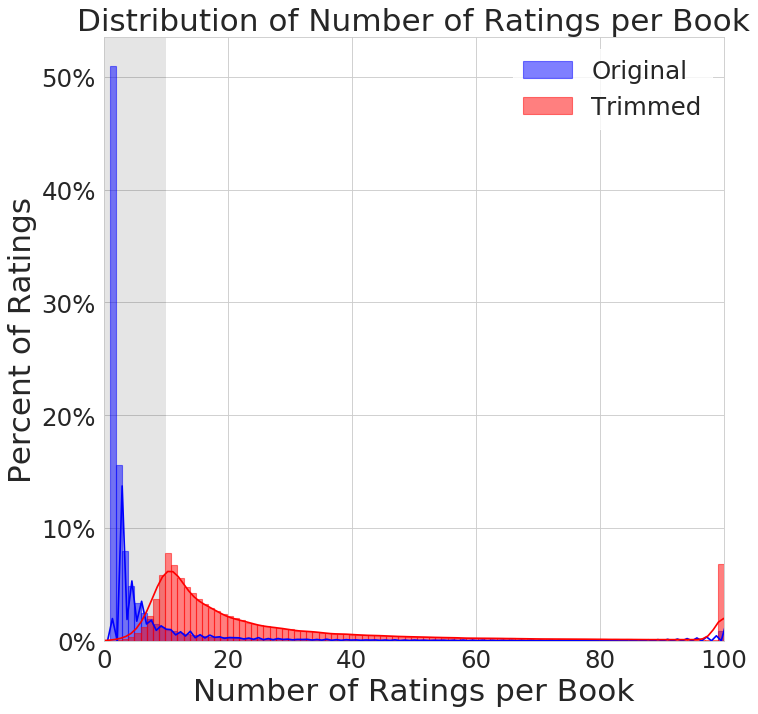

In [155]:
data1 = reviews_df.groupby('book_id')['rating'].count().clip(upper=100)
data2 = reviews_trimmed_df.groupby('book_id')['rating'].count().clip(upper=100)

import matplotlib.ticker as mtick

plt.figure(num=1, figsize=(10,10), dpi=80)
# original data
ax = sns.distplot(data1, bins=100, label='Original', norm_hist=True, color='b', hist_kws={'edgecolor':'b', 'linewidth':1, 'alpha':0.5})
# trimmed data
ax = sns.distplot(data2, bins=100, label='Trimmed' , norm_hist=True, color='r', hist_kws={'edgecolor':'r', 'linewidth':1, 'alpha':0.5}, ax=ax)
# shade trimmed area
_, ymax = ax.get_ylim()
x = [0, min_book_ratings]
plt.fill_between(x, 0, [1,1], facecolor='k', edgecolor='none', alpha=0.1)
plt.xlim((0,100))
plt.ylim(top=ymax)
# labels
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()]) # show y-axis as percent instead of fraction
plt.rc('font',size=22) # change axis tick label font size
plt.legend(loc='upper right', edgecolor='w', facecolor='w')
plt.xlabel('Number of Ratings per Book', FontSize=28)
plt.ylabel('Percent of Ratings', FontSize=28)
plt.title('Distribution of Number of Ratings per Book', FontSize=28);

## Ratings Distribution by User

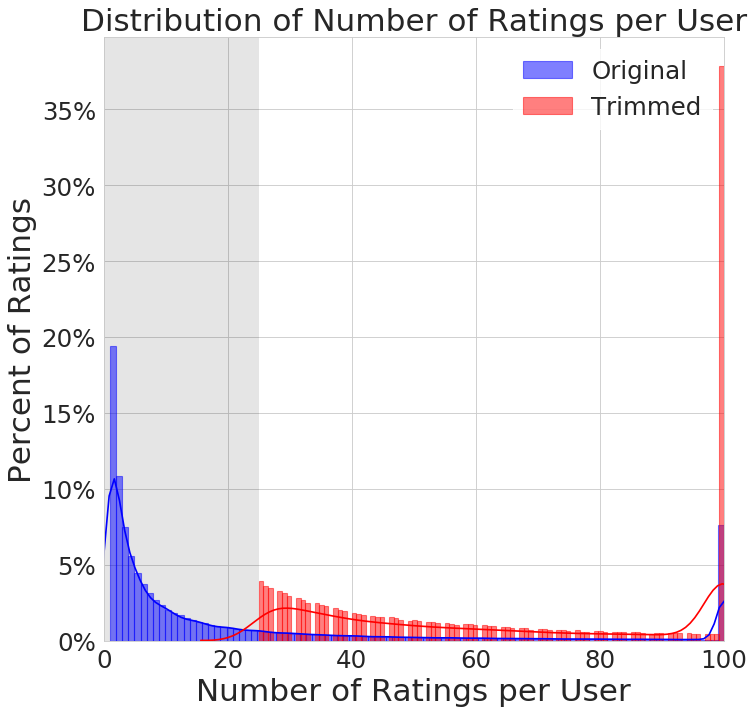

In [157]:
data1 = reviews_df.groupby('user_id')['rating'].count().clip(upper=100)
data2 = reviews_trimmed_df.groupby('user_id')['rating'].count().clip(upper=100)

plt.figure(num=1, figsize=(10,10), dpi=80)
# original data
ax = sns.distplot(data1, bins=100, label='Original', norm_hist=True, color='b', hist_kws={'edgecolor':'b', 'linewidth':1, 'alpha':0.5})
# trimmed data
ax = sns.distplot(data2, bins=100, label='Trimmed' , norm_hist=True, color='r', hist_kws={'edgecolor':'r', 'linewidth':1, 'alpha':0.5}, ax=ax)
# shade trimmed area
_, ymax = ax.get_ylim()
x = [0, min_user_ratings]
plt.fill_between(x, 0, [1,1], facecolor='k', edgecolor='none', alpha=0.1)
plt.xlim((0,100))
plt.ylim(top=ymax)
# labels
ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()]) # show y-axis as percent instead of fraction
plt.rc('font',size=22) # change axis tick label font size
plt.legend(loc='upper right', edgecolor='w', facecolor='w')
plt.xlabel('Number of Ratings per User', FontSize=28)
plt.ylabel('Percent of Ratings', FontSize=28)
plt.title('Distribution of Number of Ratings per User', FontSize=28);